In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import seaborn as sns
import os
import sys
import pickle
from glob import glob

from olympus.scalarizers import Scalarizer
from olympus.objects import ParameterVector, ParameterContinuous
from olympus.campaigns import ParameterSpace

from olympus.utils.misc import get_hypervolume, get_pareto, get_pareto_set

sns.set(style='ticks', context='notebook', font_scale=1.2)

In [2]:
#---------------------------------------
# LOAD DATASET AND SET RANK INFORMATION
#---------------------------------------

lookup = pd.read_csv('../reference-and-data/lookup_table_multiobj.csv')
print(lookup.shape)

# select only the feasible syntheses and rank them
lookup_feas = lookup[lookup.synthesis_success==1]
print(lookup_feas.shape)
lookup_feas.head()
# lookup_feas = lookup_feas.sort_values(by='abl1_pIC50', ascending=False)
# lookup_feas['rank'] = np.arange(lookup_feas.shape[0])+1
# lookup_feas.head()

(270, 12)
(213, 12)


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,kit_pIC50,pdgf_pIC50
0,8-1,22-1,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccc(C(=N)OC)cn12,COC(=N)c1ccc2ncc(C#Cc3cc(C(=O)Nc4ccc(CN5CCN(C)...,1,0.536046,0,7.390089,7.156328,7.559847,7.953599
1,8-1,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.045757,1.000000,7.617657,7.895027
3,8-1,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.065502,1.000000,7.654378,7.815624
4,8-1,22-5,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cncc2nccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,9.698970,1.000000,7.306833,7.395175
5,8-1,22-6,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,C#Cc1cnc2cnccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(C)CC3)c(C(F)(F)F)c2)...,1,1.000000,1,8.638272,1.000000,7.247814,7.504766


In [3]:
value_space = ParameterSpace()
value_space.add(ParameterContinuous(name='abl1_pIC50'))
value_space.add(ParameterContinuous(name='kit_pIC50'))
value_space.add(ParameterContinuous(name='pdgf_pIC50'))

scalarizer = Scalarizer(
                kind='Hypervolume',
                value_space=value_space,
                goals=['max', 'max', 'max'],
            )
vals = lookup_feas[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50']].values
w_ref = np.amin(vals, axis=0) # reference point for hypervolume calculation
print(w_ref)
scal_vals = scalarizer.scalarize(vals)
lookup_feas['scal_vals'] = scal_vals
lookup_feas = lookup_feas.sort_values(by='scal_vals')
lookup_feas

[4.87859145 6.13139626 5.69063761]


/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/1656909073.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lookup_feas['scal_vals'] = scal_vals


,template_name,alkyne_name,template_smi,alkyne_smi,molecule_smi,synthesis_success,synthesis_success_prob,is_experiment_x,abl1_pIC50,abl1_pIC50_std,kit_pIC50,pdgf_pIC50,scal_vals
30,8-2,22-4,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,C#Cc1cnc2cccnn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,1,1.000000,1,7.920819,1.000000,7.906951,7.924232,0.000000
28,8-2,22-2,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,C#Cc1cnc2ccccn12,Cc1ccc(C(=O)Nc2ccc(CN3CCN(CCO)CC3)c(C(F)(F)F)c...,1,1.000000,1,7.721246,1.000000,7.873886,8.008555,0.048383
248,19,22-6,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cnc2cnccn12,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5cnccn45)n(C...,1,1.000000,1,9.397940,1.000000,7.446388,7.553269,0.082522
256,19,22-14,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cnc2cn[nH]c2c1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cnc5cn[nH]c5c4)...,1,1.000000,1,8.221849,1.000000,7.654087,7.804045,0.108267
263,19,22-21,CN1CCN(Cc2ccc(NC(=O)Nc3cc(Br)n(C)n3)cc2C(F)(F)...,C#Cc1cncnc1,CN1CCN(Cc2ccc(NC(=O)Nc3cc(C#Cc4cncnc4)n(C)n3)c...,1,1.000000,1,8.154902,1.000000,7.643421,7.828636,0.122148
...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,8-5,22-16,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccncc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccncc1,1,0.984431,0,4.961542,7.042252,6.487264,5.812753,0.999701
127,8-5,22-20,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccc(F)cc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccc(F)cc1,1,0.987699,0,4.972600,7.047935,6.681064,5.746238,0.999762
125,8-5,22-18,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1cccc(C#N)c1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1cccc(C#N)c1,1,1.000000,1,5.000000,1.000000,6.131396,5.830789,1.000000
124,8-5,22-17,Cc1ccc(C(=O)Nc2ccccc2)cc1I,C#Cc1ccccc1,Cc1ccc(C(=O)Nc2ccccc2)cc1C#Cc1ccccc1,1,1.000000,1,5.000000,1.000000,6.398337,5.690638,1.000000


In [4]:
optimal_params = ['8-2', '22-4']

In [5]:
# get the pareto set
params = lookup_feas[['template_name', 'alkyne_name']].values
vals   = -lookup_feas[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50']].values
pareto_front, pareto_set = get_pareto_set(params, vals)
pareto_set = pareto_set.tolist()

In [6]:
len(pareto_set)

19


## Load results


In [10]:
#--------
# RANDOM
#--------

# random
with open('random/results.pkl', 'rb') as content:
    data_random = pickle.load(content)

    
#---------
# GRYFFIN
#---------

# # naive
# with open('naive_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_naive_naive_0 = pickle.load(content)
# with open('naive_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_naive_fia_1000 = pickle.load(content)
    
# with open('static_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_static_naive_0 = pickle.load(content)
# with open('static_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_static_fia_1000 = pickle.load(content)
    
# with open('dynamic_gryffin-naive-0/results.pkl', 'rb') as content:
#     data_dynamic_naive_0 = pickle.load(content)
# with open('dynamic_gryffin-fia-1000/results.pkl', 'rb') as content:
#     data_dynamic_fia_1000 = pickle.load(content)
    
    
# # fwa
# with open('naive_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_naive_fwa_0 = pickle.load(content)

# with open('static_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_static_fwa_0 = pickle.load(content)
    
# with open('dynamic_gryffin-fwa-0/results.pkl', 'rb') as content:
#     data_dynamic_fwa_0 = pickle.load(content)
    
    
# fca
# with open('naive_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_naive_fca_02 = pickle.load(content)
# with open('naive_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_naive_fca_05 = pickle.load(content)
# with open('naive_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_naive_fca_08 = pickle.load(content)
    
# with open('static_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_static_fca_02 = pickle.load(content)
# with open('static_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_static_fca_05 = pickle.load(content)
# with open('static_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_static_fca_08 = pickle.load(content)
    
# with open('dynamic_gryffin-fca-0.2/results.pkl', 'rb') as content:
#     data_dynamic_fca_02 = pickle.load(content)
# with open('dynamic_gryffin-fca-0.5/results.pkl', 'rb') as content:
#     data_dynamic_fca_05 = pickle.load(content)
# with open('dynamic_gryffin-fca-0.8/results.pkl', 'rb') as content:
#     data_dynamic_fca_08 = pickle.load(content)
    
# # fia
# with open('naive_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_naive_fia_05 = pickle.load(content)
# with open('naive_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_naive_fia_1 = pickle.load(content)
# with open('naive_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_naive_fia_2 = pickle.load(content)
    
# with open('static_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_static_fia_05 = pickle.load(content)
# with open('static_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_static_fia_1 = pickle.load(content)
# with open('static_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_static_fia_2 = pickle.load(content)
    
# with open('dynamic_gryffin-fia-0.5/results.pkl', 'rb') as content:
#     data_dynamic_fia_05 = pickle.load(content)
# with open('dynamic_gryffin-fia-1/results.pkl', 'rb') as content:
#     data_dynamic_fia_1 = pickle.load(content)
# with open('dynamic_gryffin-fia-2/results.pkl', 'rb') as content:
#     data_dynamic_fia_2 = pickle.load(content)
    

#---------------
# BOTORCH - UCB
#---------------

# naive
with open('ucb/wodesc_botorch-naive-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_naive_0 = pickle.load(content)
with open('ucb/wodesc_botorch-naive-replace/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_naive_replace = pickle.load(content)
with open('ucb/wodesc_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fia_1000 = pickle.load(content)
    
with open('ucb/desc_mord_botorch-naive-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_naive_0 = pickle.load(content)
with open('ucb/desc_mord_botorch-naive-replace/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_naive_replace = pickle.load(content)
with open('ucb/desc_mord_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fia_1000 = pickle.load(content)
    
    
# fwa
with open('ucb/wodesc_botorch-fwa-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fwa_0 = pickle.load(content)
    
with open('ucb/desc_mord_botorch-fwa-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fwa_0 = pickle.load(content)
    
    
# fca
with open('ucb/wodesc_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fca_02 = pickle.load(content)
with open('ucb/wodesc_botorch-fca-0.5/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fca_05 = pickle.load(content)
with open('ucb/wodesc_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fca_08 = pickle.load(content)
    
    
with open('ucb/desc_mord_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fca_02 = pickle.load(content)
with open('ucb/desc_mord_botorch-fca-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fca_05 = pickle.load(content)
with open('ucb/desc_mord_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fca_08 = pickle.load(content)
    
# fia
with open('ucb/wodesc_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fia_05 = pickle.load(content)
with open('ucb/wodesc_botorch-fia-1/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fia_1 = pickle.load(content)
with open('ucb/wodesc_botorch-fia-2/results.pkl', 'rb') as content:
    data_wodesc_botorch_ucb_fia_2 = pickle.load(content)

with open('ucb/desc_mord_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fia_05 = pickle.load(content)
with open('ucb/desc_mord_botorch-fia-1/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fia_1 = pickle.load(content)
with open('ucb/desc_mord_botorch-fia-2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ucb_fia_2 = pickle.load(content)
    

    
#---------------
# BOTORCH - EI
#---------------

# naive
with open('ei/wodesc_botorch-naive-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_naive_0 = pickle.load(content)
# with open('ei/wodesc_botorch-naive-replace/results.pkl', 'rb') as content:
#     data_wodesc_botorch_ei_naive_replace = pickle.load(content)
with open('ei/wodesc_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fia_1000 = pickle.load(content)
    
with open('ei/desc_mord_botorch-naive-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_naive_0 = pickle.load(content)
with open('ei/desc_mord_botorch-naive-replace/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_naive_replace = pickle.load(content)
with open('ei/desc_mord_botorch-naive-fia-1000/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fia_1000 = pickle.load(content)
    
    
# fwa
with open('ei/wodesc_botorch-fwa-0/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fwa_0 = pickle.load(content)
    
with open('ei/desc_mord_botorch-fwa-0/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fwa_0 = pickle.load(content)
    
    
# fca
with open('ei/wodesc_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fca_02 = pickle.load(content)
# with open('ei/wodesc_botorch-fca-0.5/results.pkl', 'rb') as content:
#     data_wodesc_botorch_ei_fca_05 = pickle.load(content)
with open('ei/wodesc_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fca_08 = pickle.load(content)
    
    
with open('ei/desc_mord_botorch-fca-0.2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fca_02 = pickle.load(content)
with open('ei/desc_mord_botorch-fca-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fca_05 = pickle.load(content)
with open('ei/desc_mord_botorch-fca-0.8/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fca_08 = pickle.load(content)
    
# fia
with open('ei/wodesc_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fia_05 = pickle.load(content)
# with open('ei/wodesc_botorch-fia-1/results.pkl', 'rb') as content:
#     data_wodesc_botorch_ei_fia_1 = pickle.load(content)
with open('ei/wodesc_botorch-fia-2/results.pkl', 'rb') as content:
    data_wodesc_botorch_ei_fia_2 = pickle.load(content)

with open('ei/desc_mord_botorch-fia-0.5/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fia_05 = pickle.load(content)
with open('ei/desc_mord_botorch-fia-1/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fia_1 = pickle.load(content)
with open('ei/desc_mord_botorch-fia-2/results.pkl', 'rb') as content:
    data_desc_mord_botorch_ei_fia_2 = pickle.load(content)
        
    

# 0 --> without descriptors
# 0 --> with descriptors

all_data = [
    # random
    {'method': 'random', 'planner': 'random', 'params': 'random', 'desc': 'wodesc', 'acqf': 'n/a', 'data': data_random},
    # gryffin
#     # naive
#     {'method': 'naive_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'naive', 'data': data_naive_naive_0},
#     {'method': 'naive_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'naive', 'data': data_naive_fia_1000},
#     {'method': 'naive_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'naive', 'data': data_naive_fwa_0},
#     {'method': 'naive_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'naive', 'data': data_naive_fca_02},
#     {'method': 'naive_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'naive', 'data': data_naive_fca_05},
#     {'method': 'naive_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'naive', 'data': data_naive_fca_08},
#     {'method': 'naive_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'naive', 'data': data_naive_fia_05},
#     {'method': 'naive_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'naive', 'data': data_naive_fia_1},
#     {'method': 'naive_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'naive', 'data': data_naive_fia_2},
#     # static
#     {'method': 'static_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'static', 'data': data_static_naive_0},
#     {'method': 'static_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'static', 'data': data_static_fia_1000},
#     {'method': 'static_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'static', 'data': data_static_fwa_0},
#     {'method': 'static_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'static', 'data': data_static_fca_02},
#     {'method': 'static_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'static', 'data': data_static_fca_05},
#     {'method': 'static_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'static', 'data': data_static_fca_08},
#     {'method': 'static_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'static', 'data': data_static_fia_05},
#     {'method': 'static_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'static', 'data': data_static_fia_1},
#     {'method': 'static_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'static', 'data': data_static_fia_2},
#     # dynamic
#     {'method': 'dynamic_gryffin-naive-0', 'planner': 'gryffin', 'params': 'naive-0', 'desc': 'dynamic', 'data': data_dynamic_naive_0},
#     {'method': 'dynamic_gryffin-naive-fia-1000', 'planner': 'gryffin', 'params': 'naive-fia-1000', 'desc': 'dynamic', 'data': data_dynamic_fia_1000},
#     {'method': 'dynamic_gryffin-fwa-0', 'planner': 'gryffin', 'params': 'fwa-0', 'desc': 'dynamic', 'data': data_dynamic_fwa_0},
#     {'method': 'dynamic_gryffin-fca-0.2', 'planner': 'gryffin', 'params': 'fca-0.2', 'desc': 'dynamic', 'data': data_dynamic_fca_02},
#     {'method': 'dynamic_gryffin-fca-0.5', 'planner': 'gryffin', 'params': 'fca-0.5', 'desc': 'dynamic', 'data': data_dynamic_fca_05},
#     {'method': 'dynamic_gryffin-fca-0.8', 'planner': 'gryffin', 'params': 'fca-0.8', 'desc': 'dynamic', 'data': data_dynamic_fca_08},
#     {'method': 'dynamic_gryffin-fia-0.5', 'planner': 'gryffin', 'params': 'fia-0.5', 'desc': 'dynamic', 'data': data_dynamic_fia_05},
#     {'method': 'dynamic_gryffin-fia-1', 'planner': 'gryffin', 'params': 'fia-1', 'desc': 'dynamic', 'data': data_dynamic_fia_1},
#     {'method': 'dynamic_gryffin-fia-2', 'planner': 'gryffin', 'params': 'fia-2', 'desc': 'dynamic', 'data': data_dynamic_fia_2},
     # botorch - ucb
    # wodesc
     {'method': 'wodesc_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'wodesc', 'acqf': 'ucb',  'data': data_wodesc_botorch_ucb_naive_0},
     {'method': 'wodesc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_naive_replace},
     {'method': 'wodesc_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fia_1000},
     {'method': 'wodesc_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fwa_0},
     {'method': 'wodesc_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fca_02},
     {'method': 'wodesc_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fca_05},
     {'method': 'wodesc_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fca_08},
     {'method': 'wodesc_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fia_05},
     {'method': 'wodesc_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fia_1},
     {'method': 'wodesc_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'wodesc', 'acqf': 'ucb', 'data': data_wodesc_botorch_ucb_fia_2},
    # desc mord
    {'method': 'desc_mord_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_naive_0},
    {'method': 'desc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_naive_replace},
    {'method': 'desc_mord_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fia_1000},
    {'method': 'desc_mord_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fwa_0},
    {'method': 'desc_mord_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fca_02},
    {'method': 'desc_mord_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fca_05},
    {'method': 'desc_mord_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fca_08},
    {'method': 'desc_mord_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fia_05},
    {'method': 'desc_mord_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fia_1},
    {'method': 'desc_mord_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'desc-mord', 'acqf': 'ucb', 'data': data_desc_mord_botorch_ucb_fia_2},
     # botorch - ei
    # wodesc
     {'method': 'wodesc_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'wodesc', 'acqf': 'ei',  'data': data_wodesc_botorch_ei_naive_0},
     #{'method': 'wodesc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_naive_replace},
     {'method': 'wodesc_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fia_1000},
     {'method': 'wodesc_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fwa_0},
     {'method': 'wodesc_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fca_02},
     #{'method': 'wodesc_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fca_05},
     {'method': 'wodesc_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fca_08},
     {'method': 'wodesc_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fia_05},
     #{'method': 'wodesc_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fia_1},
     {'method': 'wodesc_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'wodesc', 'acqf': 'ei', 'data': data_wodesc_botorch_ei_fia_2},
    # desc mord
    {'method': 'desc_mord_botorch_naive-0', 'planner': 'botorch', 'params': 'naive-0', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_naive_0},
    {'method': 'desc_botorch_naive-replace', 'planner': 'botorch', 'params': 'naive-replace', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_naive_replace},
    {'method': 'desc_mord_botorch_naive-fia-1000', 'planner': 'botorch', 'params': 'naive-fia-1000', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fia_1000},
    {'method': 'desc_mord_botorch_fwa-0', 'planner': 'botorch', 'params': 'fwa-0', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fwa_0},
    {'method': 'desc_mord_botorch_fca-0.2', 'planner': 'botorch', 'params': 'fca-0.2', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fca_02},
    {'method': 'desc_mord_botorch_fca-0.5', 'planner': 'botorch', 'params': 'fca-0.5', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fca_05},
    {'method': 'desc_mord_botorch_fca-0.8', 'planner': 'botorch', 'params': 'fca-0.8', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fca_08},
    {'method': 'desc_mord_botorch_fia-0.5', 'planner': 'botorch', 'params': 'fia-0.5', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fia_05},
    {'method': 'desc_mord_botorch_fia-1', 'planner': 'botorch', 'params': 'fia-1', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fia_1},
    {'method': 'desc_mord_botorch_fia-2', 'planner': 'botorch', 'params': 'fia-2', 'desc': 'desc-mord', 'acqf': 'ei', 'data': data_desc_mord_botorch_ei_fia_2}

]
    
# print out the number of repeated runs for each strategy
    
print('NUM RANDOM : ', len(data_random))


print('')
print('*** BOTORCH UCB ***')
print('-'*30)


print('NUM WODESC-BOTORCH-NAIVE-0 : ', len(data_wodesc_botorch_ucb_naive_0))
print('NUM WODESC-BOTORCH-NAIVE-REPLACE : ', len(data_wodesc_botorch_ucb_naive_replace))
print('NUM WODESC-BOTORCH-FIA-1000 : ', len(data_wodesc_botorch_ucb_fia_1000))

print('NUM WODESC-BOTORCH-FWA-0 : ', len(data_wodesc_botorch_ucb_fwa_0))

print('NUM WODESC-BOTORCH-FCA-02 : ', len(data_wodesc_botorch_ucb_fca_02))
print('NUM WODESC-BOTORCH-FCA-05 : ', len(data_wodesc_botorch_ucb_fca_05))
print('NUM WODESC-BOTORCH-FCA-08 : ', len(data_wodesc_botorch_ucb_fca_08))

print('NUM WODESC-BOTORCH-FIA-05 : ', len(data_wodesc_botorch_ucb_fia_05))
print('NUM WODESC-BOTORCH-FIA-1 : ', len(data_wodesc_botorch_ucb_fia_1))
print('NUM WODESC-BOTORCH-FIA-2 : ', len(data_wodesc_botorch_ucb_fia_2))

print('NUM DESC-MORD-BOTORCH-NAIVE-0 : ', len(data_desc_mord_botorch_ucb_naive_0))
print('NUM DESC-MORD-BOTORCH-NAIVE-REPLACE : ', len(data_desc_mord_botorch_ucb_naive_replace))
print('NUM DESC-MORD-BOTORCH-FIA-1000 : ', len(data_desc_mord_botorch_ucb_fia_1000))

print('NUM DESC-MORD-BOTORCH-FWA-0 : ', len(data_desc_mord_botorch_ucb_fwa_0))

print('NUM DESC-MORD-BOTORCH-FCA-02 : ', len(data_desc_mord_botorch_ucb_fca_02))
print('NUM DESC-MORD-BOTORCH-FCA-05 : ', len(data_desc_mord_botorch_ucb_fca_05))
print('NUM DESC-MORD-BOTORCH-FCA-08 : ', len(data_desc_mord_botorch_ucb_fca_08))

print('NUM DESC-MORD-BOTORCH-FIA-05 : ', len(data_desc_mord_botorch_ucb_fia_05))
print('NUM DESC-MORD-BOTORCH-FIA-1 : ', len(data_desc_mord_botorch_ucb_fia_1))
print('NUM DESC-MORD-BOTORCH-FIA-2 : ', len(data_desc_mord_botorch_ucb_fia_2))


print('')
print('*** BOTORCH EI ***')
print('-'*30)

print('NUM WODESC-BOTORCH-NAIVE-0 : ', len(data_wodesc_botorch_ei_naive_0))
#print('NUM WODESC-BOTORCH-NAIVE-REPLACE : ', len(data_wodesc_botorch_ei_naive_replace))
print('NUM WODESC-BOTORCH-FIA-1000 : ', len(data_wodesc_botorch_ei_fia_1000))

print('NUM WODESC-BOTORCH-FWA-0 : ', len(data_wodesc_botorch_ei_fwa_0))

print('NUM WODESC-BOTORCH-FCA-02 : ', len(data_wodesc_botorch_ei_fca_02))
#print('NUM WODESC-BOTORCH-FCA-05 : ', len(data_wodesc_botorch_ei_fca_05))
print('NUM WODESC-BOTORCH-FCA-08 : ', len(data_wodesc_botorch_ei_fca_08))

print('NUM WODESC-BOTORCH-FIA-05 : ', len(data_wodesc_botorch_ei_fia_05))
#print('NUM WODESC-BOTORCH-FIA-1 : ', len(data_wodesc_botorch_ei_fia_1))
print('NUM WODESC-BOTORCH-FIA-2 : ', len(data_wodesc_botorch_ei_fia_2))

print('NUM DESC-MORD-BOTORCH-NAIVE-0 : ', len(data_desc_mord_botorch_ei_naive_0))
print('NUM DESC-MORD-BOTORCH-NAIVE-REPLACE : ', len(data_desc_mord_botorch_ei_naive_replace))
print('NUM DESC-MORD-BOTORCH-FIA-1000 : ', len(data_desc_mord_botorch_ei_fia_1000))

print('NUM DESC-MORD-BOTORCH-FWA-0 : ', len(data_desc_mord_botorch_ei_fwa_0))

print('NUM DESC-MORD-BOTORCH-FCA-02 : ', len(data_desc_mord_botorch_ei_fca_02))
print('NUM DESC-MORD-BOTORCH-FCA-05 : ', len(data_desc_mord_botorch_ei_fca_05))
print('NUM DESC-MORD-BOTORCH-FCA-08 : ', len(data_desc_mord_botorch_ei_fca_08))

print('NUM DESC-MORD-BOTORCH-FIA-05 : ', len(data_desc_mord_botorch_ei_fia_05))
print('NUM DESC-MORD-BOTORCH-FIA-1 : ', len(data_desc_mord_botorch_ei_fia_1))
print('NUM DESC-MORD-BOTORCH-FIA-2 : ', len(data_desc_mord_botorch_ei_fia_2))

NUM RANDOM :  50

*** BOTORCH UCB ***
------------------------------
NUM WODESC-BOTORCH-NAIVE-0 :  50
NUM WODESC-BOTORCH-NAIVE-REPLACE :  50
NUM WODESC-BOTORCH-FIA-1000 :  50
NUM WODESC-BOTORCH-FWA-0 :  50
NUM WODESC-BOTORCH-FCA-02 :  31
NUM WODESC-BOTORCH-FCA-05 :  50
NUM WODESC-BOTORCH-FCA-08 :  47
NUM WODESC-BOTORCH-FIA-05 :  50
NUM WODESC-BOTORCH-FIA-1 :  20
NUM WODESC-BOTORCH-FIA-2 :  50
NUM DESC-MORD-BOTORCH-NAIVE-0 :  50
NUM DESC-MORD-BOTORCH-NAIVE-REPLACE :  50
NUM DESC-MORD-BOTORCH-FIA-1000 :  50
NUM DESC-MORD-BOTORCH-FWA-0 :  18
NUM DESC-MORD-BOTORCH-FCA-02 :  42
NUM DESC-MORD-BOTORCH-FCA-05 :  50
NUM DESC-MORD-BOTORCH-FCA-08 :  1
NUM DESC-MORD-BOTORCH-FIA-05 :  7
NUM DESC-MORD-BOTORCH-FIA-1 :  7
NUM DESC-MORD-BOTORCH-FIA-2 :  50

*** BOTORCH EI ***
------------------------------
NUM WODESC-BOTORCH-NAIVE-0 :  50
NUM WODESC-BOTORCH-FIA-1000 :  50
NUM WODESC-BOTORCH-FWA-0 :  50
NUM WODESC-BOTORCH-FCA-02 :  50
NUM WODESC-BOTORCH-FCA-08 :  50
NUM WODESC-BOTORCH-FIA-05 :  50
NUM W

In [11]:
#-------------
# SET PALETTE
#-------------
mypalette = {
        'random': ['gray'],
        'naive':['#c7f9cc', '#57cc99'], #'#2d6a4f'], 
        'fwa':['#ff9b85'], 
        'fca':['#fbe9b1', '#f4cb48', '#ae870a'], 
        'fia':['#caf0f8', '#00b4d8', '#0077b6'],
}

In [12]:
def get_single_traces(campaigns):
    traces = []
    for campaign in campaigns:
        trace = campaign.best_values
        assert trace.shape[1]==1
        traces.append(trace)
    return np.array(traces).squeeze(axis=-1)

def fill_nans(arr):
    mask = np.isnan(arr)
    idx = np.where(~mask,np.arange(mask.shape[1]),0)
    np.maximum.accumulate(idx,axis=1, out=idx)
    out = arr[np.arange(idx.shape[0])[:,None], idx]
    return out
    

def get_traces(campaigns, scalarizer, return_n_best_params=10):
    traces = []
    best_n_params = []
    num_pareto_set = []
    num_evals_full_pareto = []
    num_evals_one_pareto = []
    num_evals_best = []
    for df in campaigns:
#         print(campaign.observations.get_values().shape)
        df = df.fillna(method='ffill',axis=0)
        if np.isnan(df.iloc[0, -3:]['abl1_pIC50']):
            df.iloc[0, -3:] = 0.
        values = df[['abl1_pIC50', 'kit_pIC50', 'pdgf_pIC50_col']].values
       
        params = df[['template', 'alkyne']].values
        scalarized = scalarizer.scalarize(values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        #instance_trace = []
        trace0 = values[trace_best_idx, 0]
        trace1 = values[trace_best_idx, 1]
        trace2 = values[trace_best_idx, 2]
        traces.append([trace0, trace1, trace2])
        sort_idx = np.argsort(scalarized)
        best_n_params.append(list(params[sort_idx][:return_n_best_params]))
        
        num_pareto = 0
        num_pareto_ = []
        
        for ix, param in enumerate(params):
            if param.tolist() in pareto_set:
                num_pareto+=1
            num_pareto_.append(num_pareto)
            if param.tolist()==optimal_params:
                num_evals_best.append(ix+1)
        num_pareto_set.append(num_pareto_)
        
        num_evals_full_pareto.append(
            np.where(np.array(num_pareto_)==len(pareto_set))[0][0]+1
        )
        num_evals_one_pareto.append(
            np.where(np.array(num_pareto_)>0.)[0][0]+1
        )
    return (
            np.array(traces), np.array(num_pareto_set), 
            np.array(num_evals_full_pareto), np.array(num_evals_one_pareto),
            best_n_params, np.array(num_evals_best)
    )


def get_frac_top_k(campaigns, dataset, scalarizer, k):
    ''' returns the fraction of tolerable candidates measuremd at each iteration
    '''
    traces = []
    
    values = dataset.targets.values
    scalarized = scalarizer.scalarize(values)
    sort_idxs = np.argsort(scalarized, axis=0)
    sort_values = [values[i] for i in sort_idxs]
    
    for campaign in campaigns:
        campaign_trace = []
        campaign_values = campaign.observations.get_values()
        for val_ix in range(len(campaign_values)):
            campaign_trace.append(
                sum(val in campaign_values[:val_ix] for val in sort_values)/ len(sort_values)
            )
        traces.append(campaign_trace)
        
    return np.array(traces)

def plot_trace_mean(traces, obj_num=0, ax=None, color=None, label=None, use_std_err=True, linewidth=2):

    if obj_num==None:
        pass
    elif isinstance(obj_num, int):
        traces = traces[:, obj_num, :]
        
    if ax is None:
        fig, ax = plt.subplots()
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=linewidth+1, zorder=11)
    ax.plot(x, mean, color=color, linewidth=linewidth, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


def plot_trace_single(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
    with open(pkl_file, 'rb') as content:
        data = pickle.load(content)
    plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    
    
def get_num_nans(data, num_evals):
    num_nans = []
    for d, num_eval in zip(data, num_evals):
        vals = d['abl1_pIC50'].values[:num_eval]
        num_nans.append(np.sum(np.isnan(vals)))
        
    return num_nans

In [13]:
num_evals_full_par = {'method': [], 'desc': [], 'planner': [], 'params': [], 'acqf': [],  'num_evals': [], 'num_evals_one': [],
                      'num_evals_best': [], 'num_nans': [] ,
                      'per_explore': [],
                      'per_nans': [],
                    }
for elem in all_data:

    traces, num_pareto, num_evals_full_pareto, num_evals_one_pareto, _, num_evals_best = get_traces(elem['data'], scalarizer)

    num_nans = get_num_nans(elem['data'], num_evals_full_pareto)
    elem['traces'] = traces
    elem['frac_pareto'] = num_pareto/len(pareto_set)
    
    num_runs = len(num_evals_full_pareto)
    num_evals_full_par['method'].extend([elem['method'] for _ in range(num_runs)])
    if elem['planner']=='random':
        desc_ = False 
    else:
        desc_ = elem['desc']
        
    per_explore = (np.array(num_evals_full_pareto) / 270) * 100.
    per_nans    = (np.array(num_nans)/np.array(num_evals_full_pareto))*100.
        
    num_evals_full_par['desc'].extend([desc_ for _ in range(num_runs)])
    num_evals_full_par['planner'].extend([elem['planner'] for _ in range(num_runs)])
    num_evals_full_par['params'].extend([elem['params'] for _ in range(num_runs)])
    num_evals_full_par['acqf'].extend([elem['acqf'] for _ in range(num_runs)])
    num_evals_full_par['num_evals'].extend(num_evals_full_pareto.tolist())
    num_evals_full_par['num_evals_one'].extend(num_evals_one_pareto.tolist())
    num_evals_full_par['num_evals_best'].extend(num_evals_best.tolist())
    num_evals_full_par['num_nans'].extend(num_nans)
    
    num_evals_full_par['per_explore'].extend(list(per_explore))
    num_evals_full_par['per_nans'].extend(list(per_nans))
    
df_num_eval = pd.DataFrame(num_evals_full_par)

In [14]:
df_num_eval

,method,desc,planner,params,acqf,num_evals,num_evals_one,num_evals_best,num_nans,per_explore,per_nans
0,random,False,random,random,n/a,246,19,35,54,91.111111,21.951220
1,random,False,random,random,n/a,258,25,65,55,95.555556,21.317829
2,random,False,random,random,n/a,233,10,34,49,86.296296,21.030043
3,random,False,random,random,n/a,270,10,13,57,100.000000,21.111111
4,random,False,random,random,n/a,247,43,99,54,91.481481,21.862348
...,...,...,...,...,...,...,...,...,...,...,...
1668,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,ei,122,27,45,29,45.185185,23.770492
1669,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,ei,173,18,48,31,64.074074,17.919075
1670,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,ei,153,1,20,39,56.666667,25.490196
1671,desc_mord_botorch_fia-2,desc-mord,botorch,fia-2,ei,193,5,38,30,71.481481,15.544041


In [16]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(
#         data=df_num_eval, 
#         x='params', y='num_evals_best', hue='desc', ax=ax, showmeans=True)

# plt.xticks(rotation=30)

# ax.set_yscale('log')
# plt.tight_layout()
# plt.savefig('num_evals_best.png', dpi=300)

In [17]:
#df_num_eval.groupby(by=['params', 'desc']).mean()

In [18]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(data=df_num_eval, x='params', y='num_evals', hue='desc', ax=ax, showmeans=True)

# plt.xticks(rotation=30)

# plt.tight_layout()
# plt.savefig('num_evals_full_pareto.png', dpi=300)

In [19]:
# fig, ax = plt.subplots(figsize=(10, 5))
# sns.boxplot(data=df_num_eval, x='params', y='num_evals_one', hue='desc', ax=ax, showmeans=True)

# plt.xticks(rotation=30)

In [20]:
# gb = df_num_eval.groupby(by=['planner', 'desc', 'params'])
# group = gb.get_group(('random', False, 'random'))

In [21]:
# gb.head()

[<BarContainer object of 8 artists>, <BarContainer object of 8 artists>]
[<BarContainer object of 8 artists>, <BarContainer object of 8 artists>]


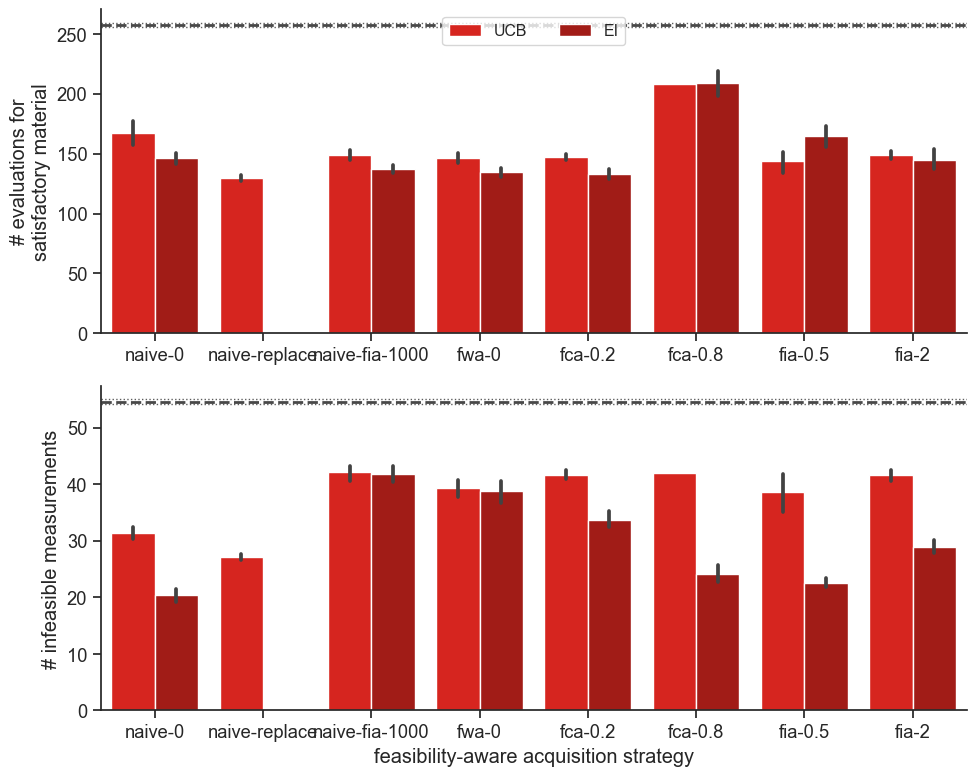

In [22]:
#-----------
# EI vs UCB
#-----------

#-------------------------------------------
# [NUM EVALS, NUM NANS] BOTORCH
#-------------------------------------------

fig, axes = plt.subplots(2, 1, figsize=(10, 8))

pal = ['#F50800', '#B80600']


#-----------
# NUM EVALS
#-----------

# compute random sampling baseline
random_mean_num_evals = df_num_eval[df_num_eval['planner']=='random']['num_evals'].mean()
random_stderr_num_evals = df_num_eval[df_num_eval['planner']=='random']['num_evals'].std() / np.sqrt(200)

data = df_num_eval[
        ~(df_num_eval['planner']=='random')&\
        ~(df_num_eval['planner']=='gryffin')&\
        ~(df_num_eval['params']=='fca-0.5')&\
        ~(df_num_eval['params']=='fia-1')&\
        ~(df_num_eval['desc']=='wodesc')
        ]

labels = ['UCB', 'EI']


# v_ = sns.boxplot(data=data, x='params', y='num_evals', hue='acqf', 
#                      showmeans=True, ax=axes[0], linewidth=1.5,  palette=pal, saturation=0.75,
#                     fliersize=3.)
b_ = sns.barplot(data=data, x='params', y='num_evals', hue='acqf', palette=pal, ax=axes[0])

handles, _ = axes[0].get_legend_handles_labels()

print(handles)

axes[0].legend(handles, labels, loc='upper center', ncol=5,fontsize=11.5)

axes[0].axhline(random_mean_num_evals, lw=2, ls='--', c='k', alpha=0.8)
axes[0].axhline(random_mean_num_evals+1.96*random_stderr_num_evals, lw=1, ls=':', c='k', alpha=0.7)
axes[0].axhline(random_mean_num_evals-1.96*random_stderr_num_evals, lw=1, ls=':', c='k', alpha=0.7)
# axes[0].legend(loc='upper center', ncol=3)
axes[0].set_xlabel('')
axes[0].set_ylabel('# evaluations for\nsatisfactory material')
#axes[0].set_title('HOIP satisfactory material')
axes[0].spines.right.set_visible(False)
axes[0].spines.top.set_visible(False)

#-----------
# NUM NANS
#-----------

# compute random sampling baseline
random_mean_num_evals = df_num_eval[df_num_eval['planner']=='random']['num_nans'].mean()
random_stderr_num_evals = df_num_eval[df_num_eval['planner']=='random']['num_nans'].std() / np.sqrt(200)

data = df_num_eval[
        ~(df_num_eval['planner']=='random')&\
        ~(df_num_eval['planner']=='gryffin')&\
        ~(df_num_eval['params']=='fca-0.5')&\
        ~(df_num_eval['params']=='fia-1')&\
        ~(df_num_eval['desc']=='wodesc')
    ]

labels = ['UCB', 'EI']


# v_ = sns.boxplot(data=data, x='params', y='num_nans', hue='acqf', 
#                      showmeans=True, ax=axes[1], linewidth=1.5,  palette=pal, saturation=0.75,
#                     fliersize=3.)

b_ = sns.barplot(data=data, x='params', y='num_nans', hue='acqf', palette=pal, ax=axes[1])

handles, _ = axes[1].get_legend_handles_labels()

print(handles)

axes[1].legend(handles, labels, loc='upper center', ncol=5,fontsize=11.5)


axes[1].axhline(random_mean_num_evals, lw=2, ls='--', c='k', alpha=0.8)
axes[1].axhline(random_mean_num_evals+1.96*random_stderr_num_evals, lw=1, ls=':', c='k', alpha=0.7)
axes[1].axhline(random_mean_num_evals-1.96*random_stderr_num_evals, lw=1, ls=':', c='k', alpha=0.7)
# axes[1].legend(loc='upper center', ncol=3)
axes[1].set_xlabel('feasibility-aware acquisition strategy')
axes[1].set_ylabel('# infeasible measurements')
#axes[1].set_title('HOIP number infeasible')
axes[1].spines.right.set_visible(False)
axes[1].spines.top.set_visible(False)

axes[1].legend([],[], frameon=False)

plt.tight_layout()

In [20]:
def get_pvalues(
        data, 
        metric, # 'botorch':['wodesc', 'desc']
        strategies={
                'random':['False'], 
                'botorch':['desc-mord'],  
#                 'gryffin':['naive', 'static', 'dynamic']
        },
        constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                     'fca-0.2', 'fca-0.5', 'fca-0.8', 
                     'fia-0.5', 'fia-1', 'fia-2'],
    ):
    res = {'planner':[],'desc':[],'params':[], 'metric': []}
    gb = data.groupby(by=['planner', 'desc', 'params'])
    # random first
    #random = data[(data['planner']=='random')&(data['desc']==False)&(data['param']=='random')][metric].to_numpy()
    group = gb.get_group(('random', False, 'random'))
    mean = group.mean()[metric]
    
    res['planner'].append('random')
    res['desc'].append(False)
    res['params'].append('random')
    res['metric'].append(mean)
    
    for alg in ['botorch']: #'gryffin']:
        for desc in strategies[alg]:
            for param in constraints:
                group = gb.get_group((alg, desc, param))
                mean = group.mean()[metric]
                res['planner'].append(alg)
                res['desc'].append(desc)
                res['params'].append(param)
                res['metric'].append(mean)
                
    df = pd.DataFrame(res).sort_values(by='metric', ascending=True)
    
    signif = []
    
    best = df.iloc[0, :][['planner', 'desc', 'params']].tolist()
    best_res = data[
            (data['planner']==best[0])&\
            (data['desc']==best[1])&\
            (data['params']==best[2])][metric].to_numpy()
    
    signif.append(best)
    
    stop = False
    idx=1
    while not stop:
        
        new = df.iloc[idx, :][['planner', 'desc', 'params']].tolist()
        new_res = data[
            (data['planner']==new[0])&\
            (data['desc']==new[1])&\
            (data['params']==new[2])][metric].to_numpy()
        
        _, pval = stats.ttest_ind(best_res, new_res, equal_var=False)
        
        if pval<0.05:
            stop=True
        else:
            signif.append(new)
            idx+=1
    return signif

In [21]:
def make_table(
    data,
    filename='mytable.txt',
    metric='num_evals_after',
    signif=[['dummy', 'dummy', 'dummy']],
    strategies={'random':['False'], 'botorch':['desc-mord']},
    constraints=['naive-0', 'naive-replace', 'naive-fia-1000', 'fwa-0', 
                 'fca-0.2', 'fca-0.5', 'fca-0.8', 
                 'fia-0.5', 'fia-1', 'fia-2'],
    num_dec=1,
):
    ''' generate a latex table with the optimization experiment results
    '''
    gb = data.groupby(by=['planner', 'desc', 'params'])
    
    num_cols = len(constraints)+1 # plus one for planner col
    num_rows = np.sum([len(val) for key, val in strategies.items()])-1 # minus 1 for random sampling
    
    col_headers = ['planner']+constraints
    
    col_str = ' '.join(['c' for _ in range(num_cols)])
    f = ''
    
    # table header
    f+='\\begin{table}[!ht]\n\centering\n\caption{\ldots}\n\label{\ldots}\n\\begin{tabular}{'+col_str+'}\n'
    f+= '\\toprule\n'
    f+= ' & '.join([header for header in col_headers]) + '\\\ \n'
    f+= '\midrule\n'
    
    # random sampling first
    f+='random & '
    group = gb.get_group(('random', False, 'random'))
    mean, sem = group.mean()[metric], group.sem()[metric]
    f += f'{round(mean,num_dec)} $\pm$ {round(sem,num_dec)} & '
    to_add = ''.join([f'$-$ & ' for _ in range(num_cols-3)])
    f+= to_add 
    f+= '$-$ \\\ \n'
    
    for alg in ['botorch']: #'gryffin']:
        for desc in strategies[alg]:
            f += f'{alg}-{desc} & '
            for param in constraints:
                group = gb.get_group((alg, desc, param))
                mean, sem = group.mean()[metric], group.sem()[metric]

                if not [alg, desc, param] in signif:
                    if param == constraints[-1]:
                        f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ \\\ \n'
                    else:
                        f += f'${round(mean,num_dec)} \pm {round(sem,num_dec)}$ &'
                else:
                    if param == constraints[-1]:
                        f+='$\\bm{'
                        f += f'{round(mean,num_dec)} \pm {round(sem,num_dec)}'
                        f+= '}$ \\\ \n'
                    else:
                        f+='$\\bm{'
                        f += f'{round(mean,num_dec)} \pm {round(sem,num_dec)}'
                        f+= '}$ & '

    # end of table
    f+='\\bottomrule\n'
    f+='\end{tabular}\n'
    f+='\end{table}\n'

    # write table to file
    with open(filename, 'w') as file:
        file.write(f)

In [22]:
# num evals for entire pareto set

df_tab = df_num_eval[~(df_num_eval['acqf']=='ucb')]


signif = get_pvalues(data=df_tab, metric='num_evals')
make_table(
    data=df_tab,
    filename='num_eval_full_pareto.txt',
    metric='num_evals',
    signif=signif,
)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:29: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/3892189700.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition,

In [23]:
# num nans for entire pareto set
signif = get_pvalues(data=df_tab, metric='num_nans')
make_table(
    data=df_tab,
    filename='num_nan_full_pareto.txt',
    metric='num_nans',
    signif=signif,
)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:29: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/3892189700.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition,

In [24]:
signif = get_pvalues(data=df_tab, metric='per_explore')
make_table(
    data=df_tab,
    filename='per_explore_full_pareto.txt',
    metric='per_explore',
    signif=signif,
)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:29: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/3892189700.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition,

In [25]:
signif = get_pvalues(data=df_tab, metric='per_nans')
make_table(
    data=df_tab,
    filename='per_nans_full_pareto.txt',
    metric='per_nans',
    signif=signif,
)

/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:18: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/342583719.py:29: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean = group.mean()[metric]
/var/folders/b7/skyhqqz10kv5ht16t37st2pm0000gn/T/ipykernel_28014/3892189700.py:33: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition,